In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')


In [2]:
import numpy as np
from scipy.io import loadmat
import glob
import re
import os

In [3]:
def make_dataset(data_src, num_samples, class_):
    
    # 获取目标文件夹数据
    req_key = "_DE_time" 
    pattern = re.compile(req_key)
    files = glob.glob(data_src)
    files = np.sort(files)
    data = loadmat(files[0])
    keysList = [key for key in data]
    for key in keysList:
        if pattern.search(key):
            my_key = key
    drive_end_data = data[my_key]
    drive_end_data = drive_end_data.reshape(-1) # 变一维
    # 分割数据块
    num_segments = np.floor(len(drive_end_data)/num_samples)
    slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
    silces = np.array(slices).reshape(int(num_segments), num_samples)
    segmented_data = silces
    # 预防性操作
    files = files[1:]
    for file in files:
        data = loadmat(file)
        keysList = [key for key in data]
        for key in keysList:
            if pattern.search(key):
                my_key = key
        drive_end_data = data[my_key]
        drive_end_data = drive_end_data.reshape(-1)
        num_segments = np.floor(len(drive_end_data)/num_samples)
        slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
        silces = np.array(slices).reshape(int(num_segments), num_samples)
        segmented_data = np.concatenate( (segmented_data, silces) , axis=0, out=None)
    
    segmented_data = np.unique(segmented_data, axis= 0) # remove duplicates
    np.random.shuffle( segmented_data) # suffule the data
    Class_ = np.ones(len(segmented_data)).astype(int)*class_
    
    return segmented_data, Class_

In [4]:
num_samples = 1200 #样本点数
fs = 12000; # 采样频率

In [5]:
data_path = r'F:\Dateset\CWRU' # 数据集路径

cls_1 = '12K_DE_Normal/*'; 
cls_2 = '12k_DE_IRFault_0.007/*';   """ cls_3 = '12k_DE_IRFault_0.014/*';   cls_4 = '12k_DE_IRFault_0.021/*'; """  
cls_5 = '12k_DE_BallFault_0.007/*';"""  cls_6 = '12k_DE_BallFault_0.014/*'; cls_7 = '12k_DE_BallFault_0.021/*' """
""" cls_8 = '12k_DE_ORFault_0.007/*';   """ """ cls_9 = '12k_DE_ORFault_0.014/*';   cls_10 ='12k_DE_ORFault_0.021/*' """

norm, y_norm = make_dataset(os.path.join(data_path, cls_1), num_samples, 1)
defc1, y_defc1 = make_dataset(os.path.join(data_path, cls_2), num_samples, 2)
""" defc2, y_defc2 = make_dataset(os.path.join(data_path, cls_3), num_samples, 3)
defc3, y_defc3 = make_dataset(os.path.join(data_path, cls_4), num_samples, 4) """
defc4, y_defc4 = make_dataset(os.path.join(data_path, cls_5), num_samples, 5)
""" defc5, y_defc5 = make_dataset(os.path.join(data_path, cls_6), num_samples, 6)
defc6, y_defc6 = make_dataset(os.path.join(data_path, cls_7), num_samples, 7) """
""" defc7, y_defc7 = make_dataset(os.path.join(data_path, cls_8), num_samples, 8) """
""" defc8, y_defc8 = make_dataset(os.path.join(data_path, cls_9), num_samples, 9)
defc9, y_defc9 = make_dataset(os.path.join(data_path, cls_10), num_samples, 10) """

' defc8, y_defc8 = make_dataset(os.path.join(data_path, cls_9), num_samples, 9)\ndefc9, y_defc9 = make_dataset(os.path.join(data_path, cls_10), num_samples, 10) '

In [6]:
""" X = np.concatenate((norm, defc1, defc2, defc3, defc4, defc5, defc6, defc7, defc8, defc9), axis=0, out=None)
Y = np.concatenate((y_norm, y_defc1, y_defc2, y_defc3, y_defc4, y_defc5, 
                    y_defc6, y_defc7, y_defc8, y_defc9), axis=0, out=None)
 """
X = np.concatenate((norm, defc1, defc4), axis=0, out=None)
Y = np.concatenate((y_norm, y_defc1, y_defc4), axis=0, out=None)

In [7]:
import pywt
from scipy.fftpack import fft
import matplotlib.pyplot as plt

In [8]:
def apply_fft(x, fs, num_samples):
    f = np.linspace(0.0, (fs/2.0), num_samples//2)
    freq_values = fft(x)
    freq_values = 2.0/num_samples * np.abs(freq_values[0:num_samples//2])
    return f, freq_values

In [9]:
wavelet_function = "db4"
num_levels = 3 # 
m = 1 # 

num_features = 2**num_levels
features = np.repeat(np.nan, len(X)*m*num_features).reshape(len(X),m*num_features)

for i in range(len(X)):    
    wp = pywt.WaveletPacket(X[i], wavelet = wavelet_function, maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        
        maximal_idx = np.argpartition(z, -m)[-m:]
        high_amp = z[maximal_idx]
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq
        
        l = 0
        for f in feature:
            features[i,j*m+l] = f
            l = l+1

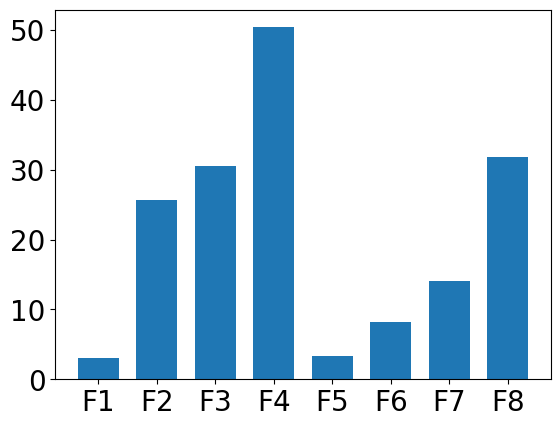

In [10]:
plt.rc('font', size=20)
X_Labels = ['F1','F2','F3','F4','F5','F6','F7','F8']
plt.bar(X_Labels, features[0], 0.7)#,  size=15)
plt.show()

In [11]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

In [12]:
## 划分测试集和训练集
train_ratio = 0.8 # 训练集比例

""" data = pd.read_csv('seeds_dataset.txt', header=None, delim_whitespace=True) # delim_whitespace=True表示分割符为空白字符
data.info
Data = data.iloc[:, :-1].values
labels = data.iloc[:, -1].values

# 划分
X_train, X_test, Y_train, Y_test = train_test_split(Data, labels, train_size=train_ratio, stratify=labels) """

labels = pd.Categorical(Y)
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2, 
                                            stratify = labels, random_state = 42)

# 使用StandardScaler类归一化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
## 定义超圆盘分类器类
class NHCmodel(BaseEstimator, ClassifierMixin):
    def __init__(self, sigma=0) -> None:
        super().__init__()
        self.sigma = sigma
        self.classes = 0
        self.s_r = {}
        self.classifiers = {}
        self.predictData = None
        self.accuracy = 0

    def gaussian_kernel(self, x, y):
        return np.exp(-np.linalg.norm(x-y, ord=2, axis=1)**2 / (2 * (self.sigma ** 2)))
    
    def jacabian1(self, beta, X):
        """返回超圆盘的对偶问题的目标函数的雅可比矩阵
        Args:
            beta (ndarray): 为该输入样本集合下的拉格朗日系数
            X (ndarray): X为输入样本矩阵, 行为样本个数, 列为样本特征
        """
        return np.sum(X*X, 1)-2*np.sum(X@(X.T*beta), 1)
    
    def Objective_Function1(self, beta, X):
        """返回超圆盘的对偶问题的目标函数，在某一拉格朗日系数下的值
        Args:
            beta (ndarray): 为该输入样本集合下的拉格朗日系数
            X (ndarray): X为输入样本矩阵, 行为样本个数, 列为样本特征
        """
        beta = beta.reshape(-1, 1)
        # print(X)
        return np.sum(beta*np.sum(X*X, 1).reshape(-1, 1))-np.sum((beta*X)@((beta*X).T))
    
    def Objective_Function2(self, alpha, X_plus, X_minus):
        M_plus  =X_plus.shape[0]
        alpha_plus = alpha[:M_plus]
        alpha_minus = alpha[M_plus:]
        M_minus = alpha_minus.shape[0]
        result = 0
        for i in range(M_plus):
            result = result + np.sum(alpha_plus[i]*alpha_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
            - 2*np.sum(alpha_plus[i]*alpha_minus*self.gaussian_kernel(X_plus[i, :], X_minus))
        for i in range(M_minus):
            result = result + np.sum(alpha_minus[i]*alpha_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
        return result
    
    def nonlcon(self, alpha, beta_plus, beta_minus, X_plus, X_minus, r_plus, r_minus):
        M_plus  =X_plus.shape[0]
        alpha_plus = alpha[:M_plus]
        alpha_minus = alpha[M_plus:]
        M_minus = alpha_minus.shape[0]
        
        c = np.zeros((2, 1))
        for i in range(M_plus):
            c[0] = c[0] + np.sum(alpha_plus[i]*alpha_plus*self.gaussian_kernel(X_plus[i, :],X_plus))
            - np.sum(alpha_plus[i]*beta_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
            + np.sum(beta_plus[i]*beta_plus*self.gaussian_kernel(X_plus[i, :], X_plus))
        c[0] -= r_plus**2
        for i in range(M_minus):
            c[0] = c[0] + np.sum(alpha_minus[i]*alpha_minus*self.gaussian_kernel(X_minus[i, :],X_minus))
            - np.sum(alpha_minus[i]*beta_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
            + np.sum(beta_minus[i]*beta_minus*self.gaussian_kernel(X_minus[i, :], X_minus))
        c[1] -= r_minus**2
        return c.flatten()

    def fit(self, X, y):
        # 拟合函数
        classes = np.unique(y)
        Num = np.size(classes)
        beta = np.zeros((Num, y.shape[0]))
        s_and_r = np.ones((Num, X.shape[1]+1))
        # 分类求解超圆盘对偶问题拉格朗日系数，以求解s和r
        for i, class_name in enumerate(classes):
            Xx = X[y==class_name, :]
            M = Xx.shape[0]
            # 设定拉格朗日系数beta初值,一个样本一个beta
            beta_init = np.ones((M)) / M # 一维数组，但是在优化函数里面需要reshape成二维数组才能运算
            # 设线性等式约束
            Aeq1 = np.ones((1, M))
            beq1 = np.array([1])
            linearConstraint1 = LinearConstraint(Aeq1, beq1, beq1)
            # 设定beta下界
            bounds = [(1e-6, 1) for _ in range(M)] 
            # 求解beta
            result1 = minimize(self.Objective_Function1, beta_init, 
                            args=(Xx,), method='SLSQP', jac=self.jacabian1, bounds=bounds, constraints=linearConstraint1,
                            )
            beta[i-1, :M] = result1.x
            
            s = np.sum(result1.x.reshape(-1, 1)*Xx, 0)
            r = np.max(np.linalg.norm(Xx-s, ord=2,axis=1))
            s_and_r[i-1, :] = np.concatenate([s, [r]])
            
            self.s_r = {'s': s,
                        'r': r}
        # 求解多个分类器的参数，即分类超平面参数，OVO策略
        Num_classifier = int(Num*(Num-1)/2)
        b_classifier = np.zeros((Num_classifier, 1))
        iter = 0
        for i in range(Num-1):
            for j in range(i+1, Num):
                iter += 1
                # 获取基本信息
                X_plus = X[y==classes[i], :]
                X_minus = X[y==classes[j], :]
                M_plus = X_plus.shape[0]
                M_minus = X_minus.shape[0]
                # 设定超平面参数初值，都为列
                alpha_plus = np.ones((M_plus)) / M_plus
                alpha_minus = np.ones((M_minus)) / M_minus
                alpha_init = np.concatenate((alpha_plus, alpha_minus), axis=0)
                # 设定线性等式约束
                Aeq2 = np.zeros((2, M_plus+M_minus))
                Aeq2[0,:M_plus] = 1;
                Aeq2[1, M_plus:] = 1
                beq2 = np.array([1, 1])
                linearConstraint2 = LinearConstraint(Aeq2, beq2, beq2)
                # 设定不等式约束
                r_plus = s_and_r[i, -1]
                r_minus = s_and_r[j, -1]
                beta_plus = beta[i, :M_plus]
                beta_minus = beta[j, :M_minus]
                lb = -np.inf
                ub = np.array([0, 0])
                # NonlinearConstraint(lambda x: NHCmodel.nonlcon(x, beta_plus, beta_minus, X_plus, X_minus, r_plus_minus), lb, ub)
                # 这个和@(beta)Objective_Function1(beta, X),@(beta) 表示输入要优化的值为beta，X不动，异曲同工
                nonlinearConstraint =  NonlinearConstraint(lambda x: self.nonlcon(x, beta_plus, beta_minus, X_plus, X_minus, r_plus, r_minus), lb, ub)
                constraints = [linearConstraint2, nonlinearConstraint]
                # 求解alpha
                result2 = minimize(self.Objective_Function2, alpha_init, args=(X_plus, X_minus,),
                                   method='SLSQP', constraints=constraints)
                alpha = result2.x
                alpha_plus = alpha[:M_plus]
                alpha_minus = alpha[M_plus:]
                # 求解b
                for k in range(M_plus):
                    b_classifier[iter-1] += np.sum(alpha_plus[k]*alpha_plus*self.gaussian_kernel(X_plus[k, :], X_plus))
                for k in range(M_minus):
                    b_classifier[iter-1] -= np.sum(alpha_minus[k]*alpha_minus*self.gaussian_kernel(X_minus[k, :], X_minus))
                b_classifier[iter-1] = -1/2*b_classifier[iter-1]
                b = b_classifier[iter-1]
                self.classes = Num
                self.classifiers[(classes[i], classes[j])] = {'X+': X_plus,
                                                'X-': X_minus,
                                                'alpha+': alpha_plus,
                                                'alpha-': alpha_minus,
                                                'b': b}    
        # 保存分类器参数字典
        with open('classifiers.pkl', 'wb') as f:
            pickle.dump(self.classifiers, f)
            
        with open('classes.pkl', 'wb') as f:
            pickle.dump(self.classes, f)   
            
        with open('s_r.pkl', 'wb') as f:
            pickle.dump(self.s_r, f) 
            
        with open('predictData.pkl', 'wb') as f:
            pickle.dump(self.predictData, f)   
                             
        return 0  
                

    def predict(self,X):
        fx = np.zeros((X.shape[0], self.classes))
        indexclasses = 0
        fxij = np.zeros((X.shape[0], self.classes))
        for (i, j), classifier in self.classifiers.items():
            indexclasses += 1
            X_pl = classifier['X+']
            X_mi = classifier['X-']
            alpha_pl = classifier['alpha+']
            alpha_mi = classifier['alpha-']
            bb = classifier['b']
            
            M_plus = X_pl.shape[0]
            M_minus = X_mi.shape[0]
            
            for g in range(M_plus):
                fx[:, indexclasses-1] = fx[:, indexclasses-1] + alpha_pl[g]*self.gaussian_kernel(X_pl[g, :], X).reshape(-1)
            for g in range(M_minus):
                fx[:, indexclasses-1] = fx[:, indexclasses-1] - alpha_mi[g]*self.gaussian_kernel(X_mi[g, :], X).reshape(-1)
            
            fx[:, indexclasses-1] = np.sign(fx[:, indexclasses-1] + bb)
            fxij[:, indexclasses-1] = fx[:, indexclasses-1] 
            fx[:, indexclasses-1][fx[:, indexclasses-1]==1] = i
            fx[:, indexclasses-1][fx[:, indexclasses-1]==-1] = j
            fx[:, indexclasses-1][fx[:, indexclasses-1]==0] = 0


        y_pred = np.apply_along_axis(lambda x: np.argmax(np.bincount(x.astype(int))), axis=1, arr=fx) # axis表示假如你是n×m维度，axis=0，表示在n方向上，axis=1，表示在m方向上
        y_pred = y_pred.reshape(-1, 1)
        self.predictData = np.concatenate((X, y_pred, fxij, fx), axis=1)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.predict(X)
        y = y.reshape(-1, 1)
        accuray = np.sum(y_pred==y) / y.shape[0]
        self.accuracy = accuray
        return accuray
              

In [14]:
""" #手搓数据集划分

classes = labels.unique()
trainData = pd.DataFrame(data=None, index=None)
testData = pd.DataFrame(data=None, index=None)

for i in classes:
    classData = data.loc[labels==i, :]
    numTrain = round(train_ratio*classData.shape[0]) # 训练集样本数
    indices = np.random.permutation(classData.shape[0])
    
    trainData = pd.concat([trainData, classData.iloc[indices[0:numTrain], :]])
    testData = pd.concat([testData, classData.iloc[indices[numTrain:], :]])

trainData.info
testData.info                                            
trainData.to_csv('trainData.csv', header=0, index=0, sep='\t')
testData.to_csv('testData.csv', header=0, index=0, sep='\t') """

" #手搓数据集划分\n\nclasses = labels.unique()\ntrainData = pd.DataFrame(data=None, index=None)\ntestData = pd.DataFrame(data=None, index=None)\n\nfor i in classes:\n    classData = data.loc[labels==i, :]\n    numTrain = round(train_ratio*classData.shape[0]) # 训练集样本数\n    indices = np.random.permutation(classData.shape[0])\n    \n    trainData = pd.concat([trainData, classData.iloc[indices[0:numTrain], :]])\n    testData = pd.concat([testData, classData.iloc[indices[numTrain:], :]])\n\ntrainData.info\ntestData.info                                            \ntrainData.to_csv('trainData.csv', header=0, index=0, sep='\t')\ntestData.to_csv('testData.csv', header=0, index=0, sep='\t') "

In [15]:
"""# 网格搜索最佳sigma
param_grid = {'sigma': (2 ** np.arange(-5, 5.5, 0.5)).tolist()}

testmodel = NHCmodel()
grid_search = GridSearchCV(testmodel, param_grid=param_grid, cv=5)

grid_search.fit(Data, labels)
sigma = grid_search.best_params_
score = grid_search.best_score_
print(sigma, score)
"""

sigma = 0.25

In [16]:
## 训练
model = NHCmodel(sigma) # 必须有输入值！！
model.fit(X_train_scaled, Y_train)

d:\software\Anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
d:\software\Anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
d:\software\Anaconda3\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


0

In [17]:
# 测试
Y_pred = model.predict(X_test_scaled)

F1 Score = 1.0
Accuracy = 100.000 %


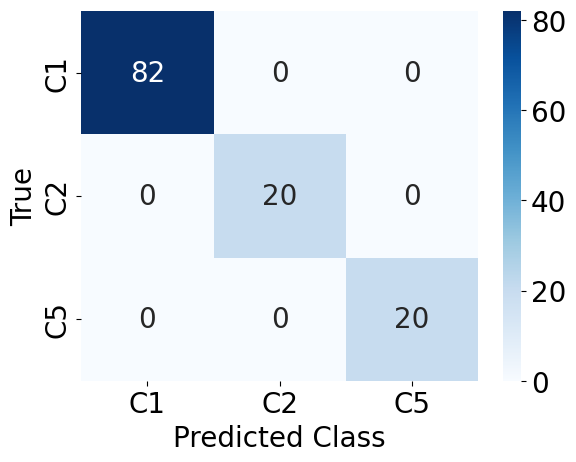

In [18]:
Accuracy = accuracy_score(Y_test, Y_pred)
# accuracy = model.score(X_test_scaled, Y_test)
test_confu_matrix = confusion_matrix(Y_test, Y_pred)
""" fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10'] """
fault_type = ['C1','C2','C5']
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.ylabel('True')
F1_score = f1_score(Y_test, Y_pred,average='micro')

print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")


In [19]:
# 多工况测试
# 创建其余工况数据
ceshi_1 = '1730_12k_DE_BallFault_0.007/*';  ceshi_2 = '1730_12k_DE_IRFault_0.007/*';   ceshi_3 = '1772_12k_DE_BallFault_0.007/*';   
ceshi_4 = '1772_12k_DE_IRFault_0.007/*';    ceshi_5 = '1797_12k_DE_BallFault_0.007/*'; ceshi_6 = '1797_12k_DE_IRFault_0.007/*';


""" ceshi_defc1, ceshi_y_defc1 = make_dataset(os.path.join(data_path, ceshi_1), num_samples, 5) """
ceshi_defc2, ceshi_y_defc2 = make_dataset(os.path.join(data_path, ceshi_2), num_samples, 2)
ceshi_defc3, ceshi_y_defc3 = make_dataset(os.path.join(data_path, ceshi_3), num_samples, 5) 
ceshi_defc4, ceshi_y_defc4 = make_dataset(os.path.join(data_path, ceshi_4), num_samples, 2)
""" ceshi_defc5, ceshi_y_defc5 = make_dataset(os.path.join(data_path, ceshi_5), num_samples, 5) """
ceshi_defc6, ceshi_y_defc6 = make_dataset(os.path.join(data_path, ceshi_6), num_samples, 2) 

ceshi_X = np.concatenate(( ceshi_defc2, ceshi_defc3, ceshi_defc4,  ceshi_defc6), axis=0, out=None)
ceshi_Y = np.concatenate(( ceshi_y_defc2, ceshi_y_defc3, ceshi_y_defc4, ceshi_y_defc6), axis=0, out=None)


In [20]:
wavelet_function = "db4"
num_levels = 3 # 
m = 1 # 

num_features = 2**num_levels
ceshi_features = np.repeat(np.nan, len(ceshi_X)*m*num_features).reshape(len(ceshi_X),m*num_features)

for i in range(len(ceshi_X)):    
    wp = pywt.WaveletPacket(ceshi_X[i], wavelet = wavelet_function, maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        
        maximal_idx = np.argpartition(z, -m)[-m:]
        high_amp = z[maximal_idx]
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq
        
        l = 0
        for f in feature:
            ceshi_features[i,j*m+l] = f
            l = l+1
            
ceshi_labels = pd.Categorical(ceshi_Y)

In [21]:
ceshi_X_scaled = scaler.transform(ceshi_features)

In [22]:
Multi_envpred = NHCmodel(sigma)

with open('classifiers.pkl', 'rb') as f:
    Multi_envpred.classifiers = pickle.load(f)
with open('classes.pkl', 'rb') as f:
    Multi_envpred.classes = pickle.load(f)
    
ceshi_Y_pred = Multi_envpred.predict(ceshi_X_scaled)

In [23]:
ceshi_Accuracy = accuracy_score(ceshi_Y, ceshi_Y_pred)
# accuracy = model.score(X_test_scaled, Y_test)

print("测试Accuracy = %.3f" % (ceshi_Accuracy*100), "%")

测试Accuracy = 88.642 %
